Processing adult, k=4...
Processing adult, k=5...
Processing adult, k=6...
Processing adult, k=7...
Processing adult, k=8...
Processing adult, k=9...
Processing adult, k=10...
Saved NMI results to results_nmi/nmi_results_adult.csv


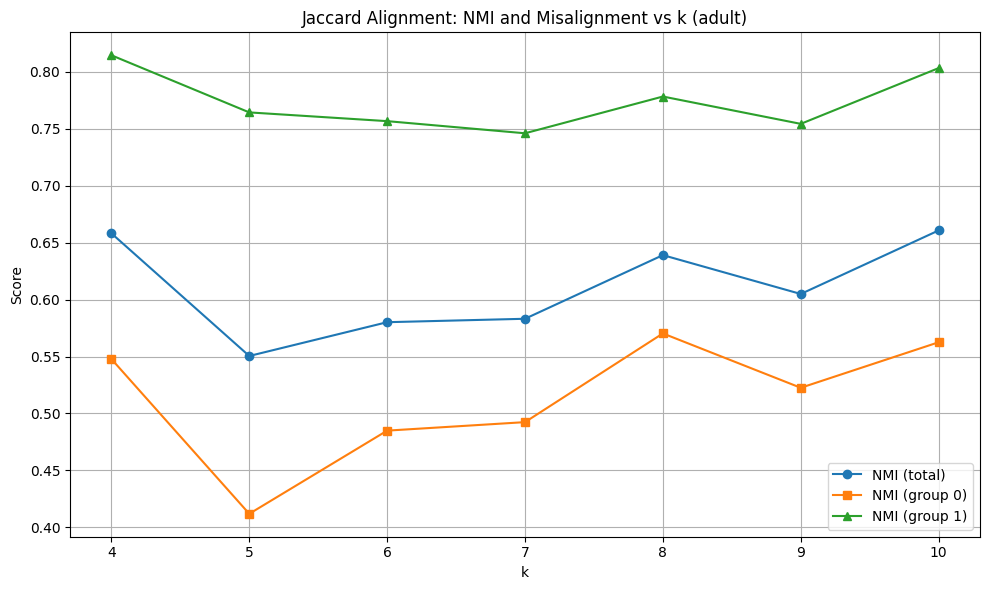

Processing credit, k=4...
Processing credit, k=5...
Processing credit, k=6...
Processing credit, k=7...
Processing credit, k=8...
Processing credit, k=9...
Processing credit, k=10...
Saved NMI results to results_nmi/nmi_results_credit.csv


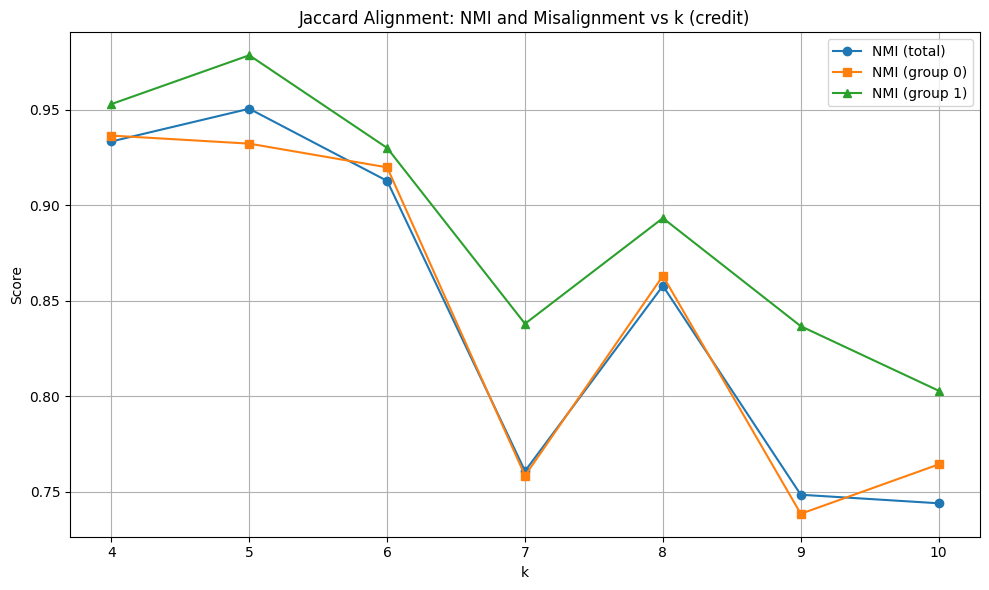

Processing bank, k=4...
Processing bank, k=5...
Processing bank, k=6...
Processing bank, k=7...
Processing bank, k=8...
Processing bank, k=9...
Processing bank, k=10...
Saved NMI results to results_nmi/nmi_results_bank.csv


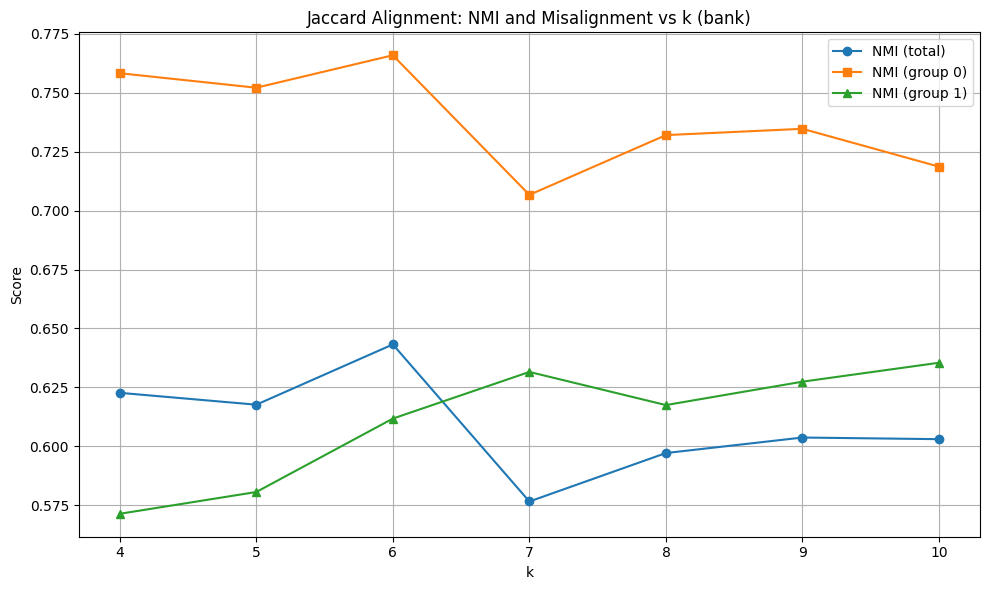

Processing student, k=4...
Processing student, k=5...
Processing student, k=6...
Processing student, k=7...
Processing student, k=8...
Processing student, k=9...
Processing student, k=10...
Saved NMI results to results_nmi/nmi_results_student.csv


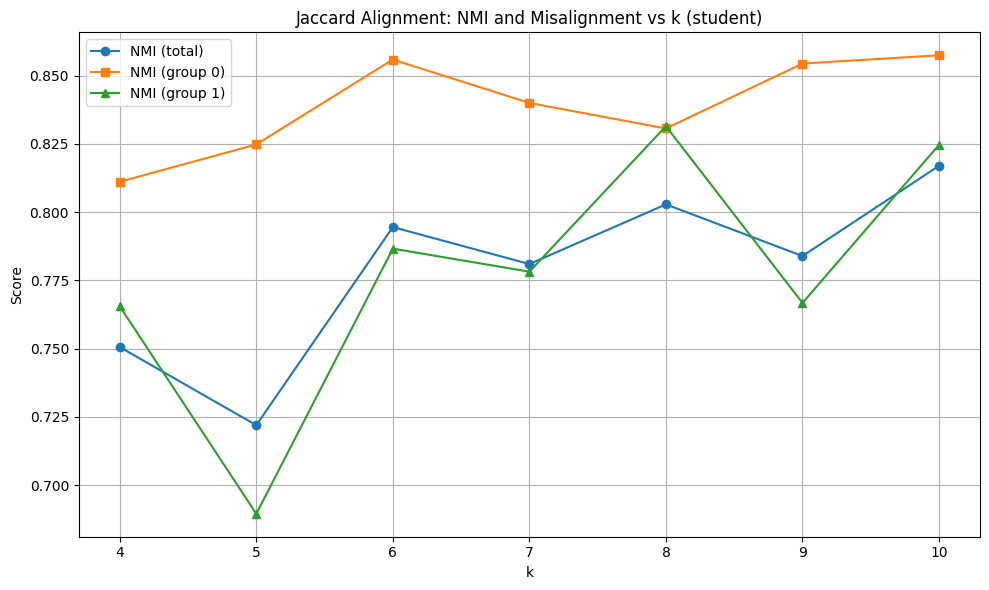

In [2]:
import pandas as pd
import numpy as np
from collections import defaultdict
from scipy.optimize import linear_sum_assignment
from sklearn.metrics import normalized_mutual_info_score
import matplotlib.pyplot as plt
import os

# Utility functions
def get_cluster_sets(labels):
    clusters = defaultdict(set)
    for idx, label in enumerate(labels):
        clusters[label].add(idx)
    return [clusters[i] for i in sorted(clusters)]

def jaccard_similarity(set1, set2):
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    return intersection / union if union != 0 else 0

def compute_similarity_matrix(unfair_clusters, fair_clusters):
    m, n = len(unfair_clusters), len(fair_clusters)
    similarity_matrix = np.zeros((m, n))
    for i in range(m):
        for j in range(n):
            similarity_matrix[i, j] = jaccard_similarity(unfair_clusters[i], fair_clusters[j])
    return similarity_matrix

def align_clusters(unfair_clusters, fair_clusters):
    similarity_matrix = compute_similarity_matrix(unfair_clusters, fair_clusters)
    cost_matrix = 1 - similarity_matrix
    row_ind, col_ind = linear_sum_assignment(cost_matrix)
    return {i: col_ind[i] for i in range(len(row_ind))}

def apply_alignment(fair_labels, alignment):
    return np.array([alignment[label] for label in fair_labels])

def get_sensitive_indices(df, dataset):
    if dataset == "adult":
        female_idx = df[df['sex'] == 0].index.values
        male_idx = df[df['sex'] == 1].index.values
    elif dataset == "credit":
        female_idx = df[df['MARRIAGE'] == 1].index.values
        male_idx = df[df['MARRIAGE'] == 2].index.values
    elif dataset == "bank":
        female_idx = df[df['marital'] == 0].index.values
        male_idx = df[df['marital'] == 1].index.values
    elif dataset == "student":
        female_idx = df[df['sex'] == 0].index.values
        male_idx = df[df['sex'] == 1].index.values
    else:
        raise ValueError(f"Unknown dataset: {dataset}")
    return female_idx, male_idx

def process_k_jaccard(k, dataset):
    df = pd.read_csv(f'output/{dataset}_violating_labeled_{k}.csv')
    unfair = df['unfair_label'].to_numpy()
    fair = df['fair_label'].to_numpy()

    cluster_unfair = get_cluster_sets(unfair)
    cluster_fair = get_cluster_sets(fair)

    alignment = align_clusters(cluster_unfair, cluster_fair)
    fair_aligned = apply_alignment(fair, alignment)

    # Compute total NMI and per group NMI
    nmi_total = normalized_mutual_info_score(unfair, fair)
    female_idx, male_idx = get_sensitive_indices(df, dataset)
    nmi_female = normalized_mutual_info_score(unfair[female_idx], fair[female_idx])
    nmi_male = normalized_mutual_info_score(unfair[male_idx], fair[male_idx])

    misaligned = np.sum(unfair != fair_aligned)

    return {
        "k": k,
        "nmi": nmi_total,
        "nmi_female": nmi_female,
        "nmi_male": nmi_male,
        "misaligned": misaligned
    }

def run_all_k_jaccard(k_range, dataset):
    results = []
    for k in k_range:
        try:
            print(f"Processing {dataset}, k={k}...")
            results.append(process_k_jaccard(k, dataset))
        except Exception as e:
            print(f"Failed at k={k} for {dataset}: {e}")
    return results

def save_nmi_results(results, dataset):
    df = pd.DataFrame(results)
    os.makedirs("results_nmi", exist_ok=True)
    df.to_csv(f"results_nmi/nmi_results_{dataset}.csv", index=False)
    print(f"Saved NMI results to results_nmi/nmi_results_{dataset}.csv")

def plot_nmi_jaccard(results, dataset):
    k_vals = [r['k'] for r in results]
    nmis = [r['nmi'] for r in results]
    nmis_f = [r['nmi_female'] for r in results]
    nmis_m = [r['nmi_male'] for r in results]
    misaligned = [r['misaligned'] for r in results]

    plt.figure(figsize=(10,6))
    plt.plot(k_vals, nmis, label='NMI (total)', marker='o')
    plt.plot(k_vals, nmis_f, label='NMI (group 0)', marker='s')
    plt.plot(k_vals, nmis_m, label='NMI (group 1)', marker='^')
    plt.xlabel('k')
    plt.ylabel('Score')
    plt.title(f'Jaccard Alignment: NMI and Misalignment vs k ({dataset})')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    os.makedirs("plots", exist_ok=True)
    plt.savefig(f"plots/jaccard_alignment_{dataset}.png")
    plt.show()

# Run for multiple datasets
if __name__ == '__main__':
    datasets = ["adult", "credit", "bank", "student"]
    k_values = range(4, 11)

    for dataset in datasets:
        results = run_all_k_jaccard(k_values, dataset)
        save_nmi_results(results, dataset)
        plot_nmi_jaccard(results, dataset)